In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from scipy import signal
from scipy.signal import cheby2, freqz, filtfilt

In [9]:
#Functions

#Nan interpolation function
def Nan_interpolation(input_sig):
    nan_indices = np.isnan(input_sig)
    non_nan_indices = np.arange(len(input_sig))[~nan_indices]
    for indx in np.where(nan_indices)[0]:
        input_sig[nan_indices] = np.interp(indx, non_nan_indices, input_sig[non_nan_indices])
    
    return input_sig

def Notch_Detection(input_sig, peaks_indx, valleys_indx):
    dnotch_indx = np.empty((0,), dtype = int)

    # Notch detection(peak이후 valley 이전, 2차 미분 후 0 이상 최대 피크값)
    LPF_sig_fder = np.gradient(input_sig)
    LPF_sig_sder = np.gradient(LPF_sig_fder)

    for i in range(valleys_indx.shape[0]-1):
        temp_indx_array = signal.find_peaks(LPF_sig_sder[peaks_indx[i+1]:valleys_indx[i+1]], height=0)
        if len(temp_indx_array[0]) == 0: # Dicrotic Notch가 보이지 않는 경우
            temp_indx = -1
        else:
            temp_indx = temp_indx_array[0][np.argmax(LPF_sig_sder[temp_indx_array[0]])] + peaks_indx[i+1]
        
        dnotch_indx = np.append(dnotch_indx, temp_indx)
    
    return dnotch_indx

def Valley_Window(input_sig, valleys_indx):
    n = len(input_sig)
    Win_indx = np.empty((0,2), dtype = int)
    for i in range(len(valleys_indx)//5-1):
        seg_s = valleys_indx[5*i]
        seg_e = valleys_indx[5*i+5]
        Win_indx = np.insert(Win_indx, Win_indx.shape[0], [seg_s, seg_e], axis = 0)
    return Win_indx

def Auto_Correlation_Filter(input_sig, win_indx):
    n = len(input_sig)
    corrupted_indx = np.empty((0,), dtype = int)
    for i in range(win_indx.shape[0]):
        seg_s = win_indx[i,0]
        seg_e = win_indx[i,1]
        auto_correlation = np.correlate(input_sig[seg_s:seg_e], input_sig[seg_s:seg_e], mode = 'full')
        auto_correlation = auto_correlation/np.max(auto_correlation)
        ac_s_peaks, _ = signal.find_peaks(auto_correlation, height=0.7)
        if len(ac_s_peaks) < 3:
            corrupted_indx = np.append(corrupted_indx, i)
    
    out_win_indx = np.delete(win_indx, corrupted_indx, axis = 0)
    return out_win_indx, corrupted_indx



# TmBB Peak to Peak distance
def TmBB_feat(sig_indx, win_num):
    
    ft_tmbb = np.empty((0,4))

    for i in range(sig_indx.shape[0]):
        ft_tmbb_temp = np.empty((0,))
        for k in range(win_num-1):
            ft_tmbb_temp = np.append(ft_tmbb_temp, sig_indx[i, (k+1)*3+1]-sig_indx[i, k*3+1])
        ft_tmbb = np.insert(ft_tmbb, ft_tmbb.shape[0], ft_tmbb_temp, axis=0)
    
    return ft_tmbb

# TmBB Peak to Peak distance
def TmCA_feat(sig_indx, win_num):
    
    ft_tmca = np.empty((0,5))

    for i in range(sig_indx.shape[0]):
        ft_tmca_temp = np.empty((0,))
        for k in range(win_num):
            ft_tmca_temp = np.append(ft_tmca_temp, sig_indx[i, 3*(k+1)]-sig_indx[i, 3*(k+1)-1])
        ft_tmca = np.insert(ft_tmca, ft_tmca.shape[0], ft_tmca_temp, axis=0)
    
    return ft_tmca

def RSD_feat(sig_indx, win_num):
    
    ft_RSD = np.empty((0,5))
    
    for i in range(sig_indx.shape[0]):
        ft_RSD_temp = np.empty((0,))
        for k in range(win_num):
            ft_RSD_temp = np.append(ft_RSD_temp, (sig_indx[i, 3*k+2]-sig_indx[i, 3*k]+1)/(sig_indx[i, 3*(k+1)]-sig_indx[i, 3*k+2]+1))
        ft_RSD = np.insert(ft_RSD, ft_RSD.shape[0], ft_RSD_temp, axis=0)
    
    return ft_RSD

def RtArea_feat(input_sig, sig_indx, win_num): # 독창적인 방법
    ft_RtArea = np.empty((0,5))
    
    for i in range(sig_indx.shape[0]):
        ft_RtArea_temp = np.empty((0,))
        for k in range(win_num):
            com_r = (input_sig[sig_indx[i, 3*(k+1)]] - input_sig[sig_indx[i,3*k]])/(sig_indx[i,3*(k+1)]-sig_indx[i,3*k])

            sum_ac = np.sum(input_sig[sig_indx[i,3*k]:sig_indx[i,3*k+2]+1]-input_sig[sig_indx[i,3*k]]) - (com_r*(sig_indx[i,3*k+2]-sig_indx[i,3*k])**2)/2
            sum_ca = np.sum(input_sig[sig_indx[i,3*k+2]:sig_indx[i,3*(k+1)]+1]-input_sig[sig_indx[i,3*k]]) - (com_r*(sig_indx[i,3*(k+1)]-sig_indx[i,3*k+2])**2)/2
            
            ft_RtArea_temp = np.append(ft_RtArea_temp, sum_ca/sum_ac)
        ft_RtArea = np.insert(ft_RtArea, ft_RtArea.shape[0], ft_RtArea_temp, axis=0)
    return ft_RtArea

def SAI_Algorithm(input_sig):
    # 1. Beat detection
    bp_peaks_indx, _ = signal.find_peaks(input_sig, distance = 60)
    bp_valleys_indx = np.empty((0,), dtype = int)
    
    for i in range(len(bp_peaks_indx)-1):
        min_indx = np.argmin(input_sig[bp_peaks_indx[i]: bp_peaks_indx[i + 1]]) + bp_peaks_indx[i]
        bp_valleys_indx = np.append(bp_valleys_indx, min_indx)
        
    # 3. Abnormality criterion
    Ps_c = 180
    Pd_c = 20
    Pm_c = [30, 200]
    f_c = [20, 200]
    Pp_c = 20
    dPs_c = 20
    dPd_c = 20
    dT_c = 2/3

    # 2. Feature Extraction & Detection
    bp_ab_indx = np.empty((0,), dtype = int)

    for i in range(len(bp_valleys_indx)-2): # 첫 부분 잘린 펄스, 첫번째 full pulse와 끝에 잘린 펄스 제외
        bp_ft_Ps = input_sig[bp_peaks_indx[i+2]]
        bp_ft_Pd = input_sig[bp_valleys_indx[i+2]]
        bp_ft_Pp = bp_ft_Ps - bp_ft_Pd
        bp_ft_Pm = (bp_ft_Ps + bp_ft_Pd)/3
        bp_ft_T = (bp_valleys_indx[i+2] - bp_valleys_indx[i+1])/125
            
        bp_ft_f = 60/bp_ft_T
        
        dPs = abs(bp_ft_Ps - input_sig[bp_peaks_indx[i+1]])
        dPd = abs(bp_ft_Pd - input_sig[bp_valleys_indx[i+1]])
        dT = bp_ft_T - (bp_valleys_indx[i+1] - bp_valleys_indx[i])/125
        
        if (bp_ft_Ps > Ps_c or bp_ft_Ps < 80 or bp_ft_Pd < Pd_c or 
        bp_ft_Pm < Pm_c[0] or bp_ft_Pm > Pm_c[1] or bp_ft_Pp < Pp_c or 
        bp_ft_f < f_c[0] or bp_ft_f > f_c[1] or dPs > dPs_c or dPd > dPd_c or dT > dT_c):
            bp_ab_indx = np.append(bp_ab_indx, bp_peaks_indx[i + 2])
            
    return bp_ab_indx, bp_peaks_indx, bp_valleys_indx

"""
def Feature_Extraction(input_sig, ACF_win_indx):
    for i in range(ACF_win_indx.shape[0]):
"""        
        
"""
def Skewness(input_sig): #associated with corrupted PPG Signal
    n = len(input_sig)
    mean = np.mean(input_sig)
    std = np.std(input_sig, ddof=1)
    skewness = np.sum(((input_sig - mean) / std) ** 3) * n / ((n - 1) * (n - 2))
    return skewness

def Kurtosis(input_sig):
    n = len(input_sig)
    mean = np.mean(input_sig)
    std = np.std(input_sig, ddof=1)
    kurtosis = np.sum(((input_sig - mean) / std) ** 4) * n * (n + 1) / ((n - 1) * (n - 2) * (n - 3)) - 3 * ((n - 1) ** 2) / ((n - 2) * (n - 3))
    return kurtosis

def NPCFD(input_sig):
    FDPPG = np.empty((len(input_sig)-1,))
    for i in range(0,len(input_sig)-1):
        FD_cube = (input_sig[i+1] - input_sig[i])**3
        if FD_cube >= 0:
            FDPPG[i]=FD_cube
        else:
            FDPPG[i] = 0
    max_val = FDPPG[np.argmax(FDPPG)]
    for i in range(len(FDPPG)):
        FDPPG[i] = FDPPG[i]/max_val
        
    return FDPPG
"""

'\ndef Skewness(input_sig): #associated with corrupted PPG Signal\n    n = len(input_sig)\n    mean = np.mean(input_sig)\n    std = np.std(input_sig, ddof=1)\n    skewness = np.sum(((input_sig - mean) / std) ** 3) * n / ((n - 1) * (n - 2))\n    return skewness\n\ndef Kurtosis(input_sig):\n    n = len(input_sig)\n    mean = np.mean(input_sig)\n    std = np.std(input_sig, ddof=1)\n    kurtosis = np.sum(((input_sig - mean) / std) ** 4) * n * (n + 1) / ((n - 1) * (n - 2) * (n - 3)) - 3 * ((n - 1) ** 2) / ((n - 2) * (n - 3))\n    return kurtosis\n\ndef NPCFD(input_sig):\n    FDPPG = np.empty((len(input_sig)-1,))\n    for i in range(0,len(input_sig)-1):\n        FD_cube = (input_sig[i+1] - input_sig[i])**3\n        if FD_cube >= 0:\n            FDPPG[i]=FD_cube\n        else:\n            FDPPG[i] = 0\n    max_val = FDPPG[np.argmax(FDPPG)]\n    for i in range(len(FDPPG)):\n        FDPPG[i] = FDPPG[i]/max_val\n        \n    return FDPPG\n'

### Loading Data

In [3]:
# 데이터 부르기
folder_path = 'H:/lab/Research/ppg_nibp/Dataset/Ex_2/MIMIC-III'
file_name = 'raw_data_p031942.npz'

file_path = folder_path + "\\" + file_name
whole_data = np.load(file_path)
ppg_sig, bp_sig = whole_data['x'], whole_data['y']

### Data Preprocessing

In [ ]:
# Preprocessing

#Nan interpolation
ppg_nan_interpolated_sig = Nan_interpolation(ppg_sig)
bp_nan_interpolated_sig = Nan_interpolation(bp_sig)

# Chebyshev LPF - 10Hz - Mo.. 거의 모든 데이터가 10Hz 내로 존재함 근거, An optimal filter for short PPG
fs = 125
order = 4
ripple = 10
cutoff_freq = [0.5, 10]
btype = 'bandpass'
nyquist_f = fs*0.5
Wn = [cutoff_freq[0]/nyquist_f, cutoff_freq[1]/nyquist_f] #0.5Hz~10Hz
b, a = cheby2(order, ripple, Wn, btype, analog=False)
ppg_BPF_sig = filtfilt(b, a, ppg_nan_interpolated_sig)

gap = ppg_nan_interpolated_sig.shape[0] - ppg_BPF_sig.shape[0]

bp_LPF_sig = bp_nan_interpolated_sig[gap:]

#Normalization으로 크기가 안 맞는 것을 보완 - 일단 하지 말아보자

# 시간 기준으로 프레임을 짜는 것이 아니라, 과거 펄스까지 이용해서 특징점 확보
# 펄스의 개수로 확보할 수 있는 특징점 달라짐

# Peak, valley detection
# Feature extraction 1 - Peak, Valley detection
# Chakraborty et al. PPG peak detection
#NPCFD_sig = NPCFD(LPF_sig)

# Peak & Valley detection 2
peaks_indx, _ = signal.find_peaks(ppg_BPF_sig, distance = 60)
valleys_indx = np.array([], dtype = np.int64)
for i in range(len(peaks_indx)-1):
    v_indx = np.argmin(ppg_BPF_sig[peaks_indx[i]: peaks_indx[i + 1]]) + peaks_indx[i]
    valleys_indx = np.append(valleys_indx, v_indx)
    
# Dicrotic Nothc in signal detection
dnotch_indx = Notch_Detection(ppg_BPF_sig, peaks_indx, valleys_indx)

# Motion Artifacts removal #Lin et al. DWT방식 사용

# Windowing according to last pulse(valley)
win_indx = Valley_Window(ppg_BPF_sig, valleys_indx)

# Auto-Correlation 방식 사용
ACF_win_indx, corrupted_win_indx = Auto_Correlation_Filter(ppg_BPF_sig, win_indx) #모든 연산, 필터링은 인덱스를 기준으로

# Notch가 없는 윈도우 제거 - 실험 결과 Auto-Correlation 방식으로 제거 됨
for i in range(dnotch_indx.shape[0]):
    if dnotch_indx[i] == -1:
        for k in range(win_indx.shape[0]):
            if dnotch_indx[i] > win_indx[k, 0] and dnotch_indx[i] < win_indx[k, 1]:
                corrupted_win_indx = np.append(corrupted_win_indx, k)
                continue
                
corrupted_win_indx = np.unique(corrupted_win_indx)

# 통계적 방법으로 극단치 제거하기
# ppg_indx: Every indx in total in each row for each window
ppg_indx_c = np.empty((0,16), dtype = int) # 윈도우 시작점 - 피크 노치 벨리 x5

for i in range(valleys_indx.shape[0]//5-1):
    temp = [valleys_indx[5*i],peaks_indx[5*i+1],dnotch_indx[5*i],
            valleys_indx[5*i+1],peaks_indx[5*i+2],dnotch_indx[5*i+1],
            valleys_indx[5*i+2],peaks_indx[5*i+3],dnotch_indx[5*i+2],
            valleys_indx[5*i+3],peaks_indx[5*i+4],dnotch_indx[5*i+3],
            valleys_indx[5*i+4],peaks_indx[5*i+5],dnotch_indx[5*i+4], valleys_indx[5*i+5]]
    ppg_indx_c = np.insert(ppg_indx_c, ppg_indx_c.shape[0], temp, axis=0)
    
ppg_indx = np.delete(ppg_indx_c, corrupted_win_indx, axis=0)

# (1) Feature Extraction - Standard Deviation of Peak to peak Amplitude
#sig_features = Feature_Extraction(LPF_sig, ACF_win_indx)
win_num = 5
ft_tmbb = TmBB_feat(ppg_indx, win_num)
ft_tmca = TmCA_feat(ppg_indx, win_num)
ft_RSD = RSD_feat(ppg_indx, win_num)
ft_RtArea = RtArea_feat(ppg_BPF_sig, ppg_indx, win_num)

# all feature array
ft_num = 4
ft_length = (win_num-1) + 3*win_num
ft_array = np.empty((0, ft_length))
for i in range(ft_num):
    ft_array = np.concatenate((ft_tmbb,ft_tmca, ft_RSD, ft_RtArea), axis=1)

# # the delay length of ppg - Cross correlation
# cross_correlation = np.correlate(ppg_BPF_sig[ppg_indx[0,0]:ppg_indx[0,3]], bp_LPF_sig[ppg_indx[0,0]:ppg_indx[0,3]], mode='full')
# half_indx = int((ppg_indx[0,0]+ppg_indx[0,3])//2)
# cc_max_indx = signal.find_peaks(cross_correlation[half_indx:])
# ppg_BPF_sig = ppg_BPF_sig[cc_max_indx[0][0]:]
# ppg_indx -= cc_max_indx

# Blood pressure preprocessing
bp_corrupted_indx, bp_peaks_indx, bp_valleys_indx = SAI_Algorithm(bp_LPF_sig)
bp_corrupted_win_indx = np.empty((0,),dtype=int)
for i in range(ppg_indx.shape[0]):
    for k in range(bp_corrupted_indx.shape[0]):
        if ppg_indx[i,0] < bp_corrupted_indx[k] and ppg_indx[i,-1] > bp_corrupted_indx[k]:
            bp_corrupted_win_indx = np.append(bp_corrupted_win_indx, i)
            break
            
ppg_indx = np.delete(ppg_indx, bp_corrupted_win_indx, axis = 0)
ft_array = np.delete(ft_array, bp_corrupted_win_indx, axis = 0)

# Remove BP corrupted window
bp_corrupted_indx_2 = np.empty((0,), dtype = int)
for i in range(ppg_indx.shape[0]):
    bp_peak_temp, _ = signal.find_peaks(bp_LPF_sig[ppg_indx[i,12]:ppg_indx[i,15]])
    if len(bp_peak_temp)==0:
        bp_corrupted_indx_2 = np.append(bp_corrupted_indx_2, i)
        
ppg_indx = np.delete(ppg_indx, bp_corrupted_indx_2, axis = 0)
ft_array = np.delete(ft_array, bp_corrupted_indx_2, axis = 0)

# BP value_ delay 보상되어 필요 없는 피크, 벨리 제거
for i in range(bp_peaks_indx.shape[0]):
    if bp_peaks_indx[i]>ppg_indx[0,0]:
        bp_peaks_indx = np.delete(bp_peaks_indx, range(0,i), axis = 0)
        bp_valleys_indx = np.delete(bp_valleys_indx, range(0,i), axis=0)
        break

# window별 마지막 펄스에 해당하는 수축기 이완기 혈압 추출
label_array = np.empty((0,2))
bp_corrupted_indx_2 = np.empty((0,), dtype = int)
sum = 0
for i in range(ppg_indx.shape[0]):
    bp_peak_temp, _ = signal.find_peaks(bp_LPF_sig[ppg_indx[i,12]:ppg_indx[i,15]])
    sbp = bp_LPF_sig[bp_peak_temp[0]+ppg_indx[i,12]]
    dbp = np.min(bp_LPF_sig[ppg_indx[i,13]:ppg_indx[i,15]+cc_max_indx])
    label_array = np.insert(label_array, label_array.shape[0], [sbp, dbp], axis = 0)

131


Text(0, 0.5, 'Amplitude')

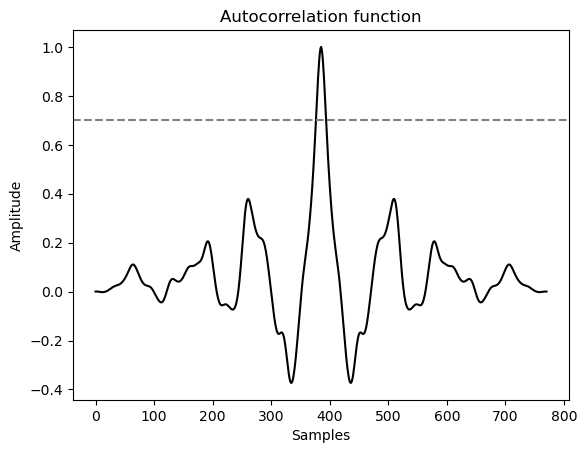

In [39]:
corrupted_indx = np.empty((0,), dtype = int)

for i in range(3000):
    
    seg_s = win_indx[i,0]
    seg_e = win_indx[i,1]
    auto_correlation = np.correlate(ppg_BPF_sig[seg_s:seg_e], ppg_BPF_sig[seg_s:seg_e], mode = 'full')
    auto_correlation = auto_correlation/np.max(auto_correlation)
    ac_s_peaks, _ = signal.find_peaks(auto_correlation, height=0.6)
    if ac_s_peaks.shape[0] <3:
        print(i)
        break

plt.plot(auto_correlation, color = 'k')
plt.title('Autocorrelation function')
plt.axhline(y=0.7, color='gray', linestyle='--', label='Horizontal Line at y=7')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

### Plot to see if functions are working

In [37]:
dnotch_indx = np.empty((0,), dtype = int)

# Notch detection(peak이후 valley 이전, 2차 미분 후 0 이상 최대 피크값)
LPF_sig_fder = np.gradient(LPF_sig)
LPF_sig_sder = np.gradient(LPF_sig_fder)

for i in range(valleys_indx.shape[0]-1):
    temp_indx_array = signal.find_peaks(LPF_sig_sder[peaks_indx[i+1]:valleys_indx[i+1]], height=0)
    if len(temp_indx_array[0]) == 0: # Dicrotic Notch가 보이지 않는 경우
        temp_indx = -1
    else:
        temp_indx = temp_indx_array[0][np.argmax(LPF_sig_sder[temp_indx_array[0]])] + peaks_indx[i+1]
    dnotch_indx = np.append(dnotch_indx, temp_indx)

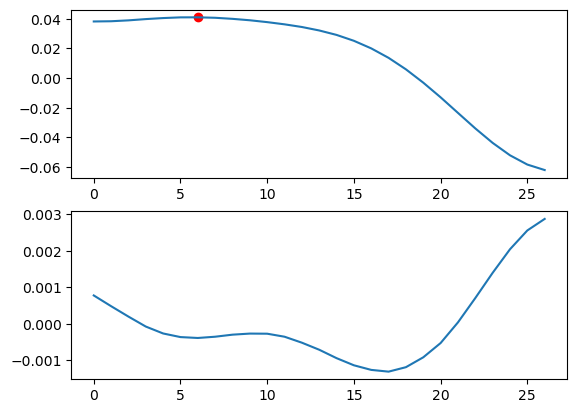

In [75]:
k = 97129
fig, ax = plt.subplots(2,1)
ax[0].plot(LPF_sig[valleys_indx[k]:valleys_indx[k+1]])
ax[0].scatter(peaks_indx[k+1]-valleys_indx[k], LPF_sig[peaks_indx[k+1]], c='r')
#ax[0].scatter(dnotch_indx[k]-valleys_indx[k], LPF_sig[dnotch_indx[k]], c='k')
ax[1].plot(LPF_sig_sder[valleys_indx[k]:valleys_indx[k+1]])
#ax[1].scatter(dnotch_indx[k]-valleys_indx[k], LPF_sig_sder[dnotch_indx[k]])

Text(0.5, 0, 'Time (ms)')

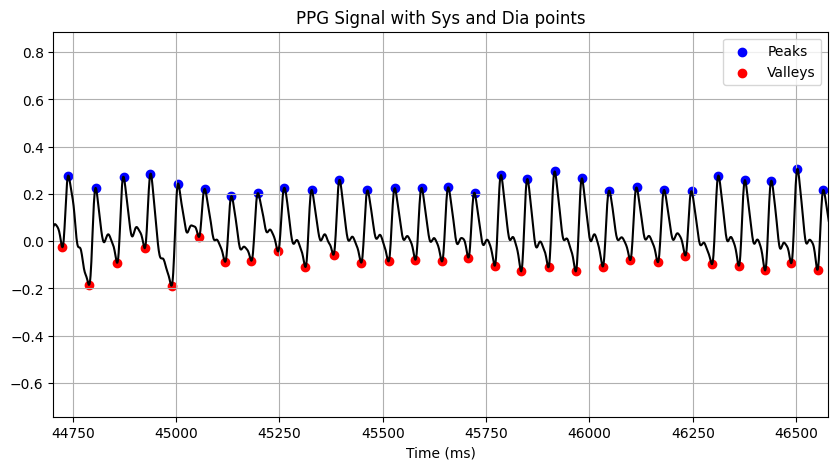

In [59]:
# Sys & Dia & point_Noth

for i in range(valleys_indx.shape-1):
    

window_s = 45328
window_size = 625
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(LPF_sig, c='k')
ax1.scatter(peaks_indx, LPF_sig[peaks_indx], c ='b', marker='o',label='Peaks')
ax1.scatter(valleys_indx, LPF_sig[valleys_indx], c='r', marker='o',label='Valleys')
ax1.set_title("PPG Signal with Sys and Dia points")
ax1.grid(True)
ax1.legend()
ax1.set_xlim(window_s-window_size, window_s + 2*window_size)
ax1.set_xlabel('Time (ms)')

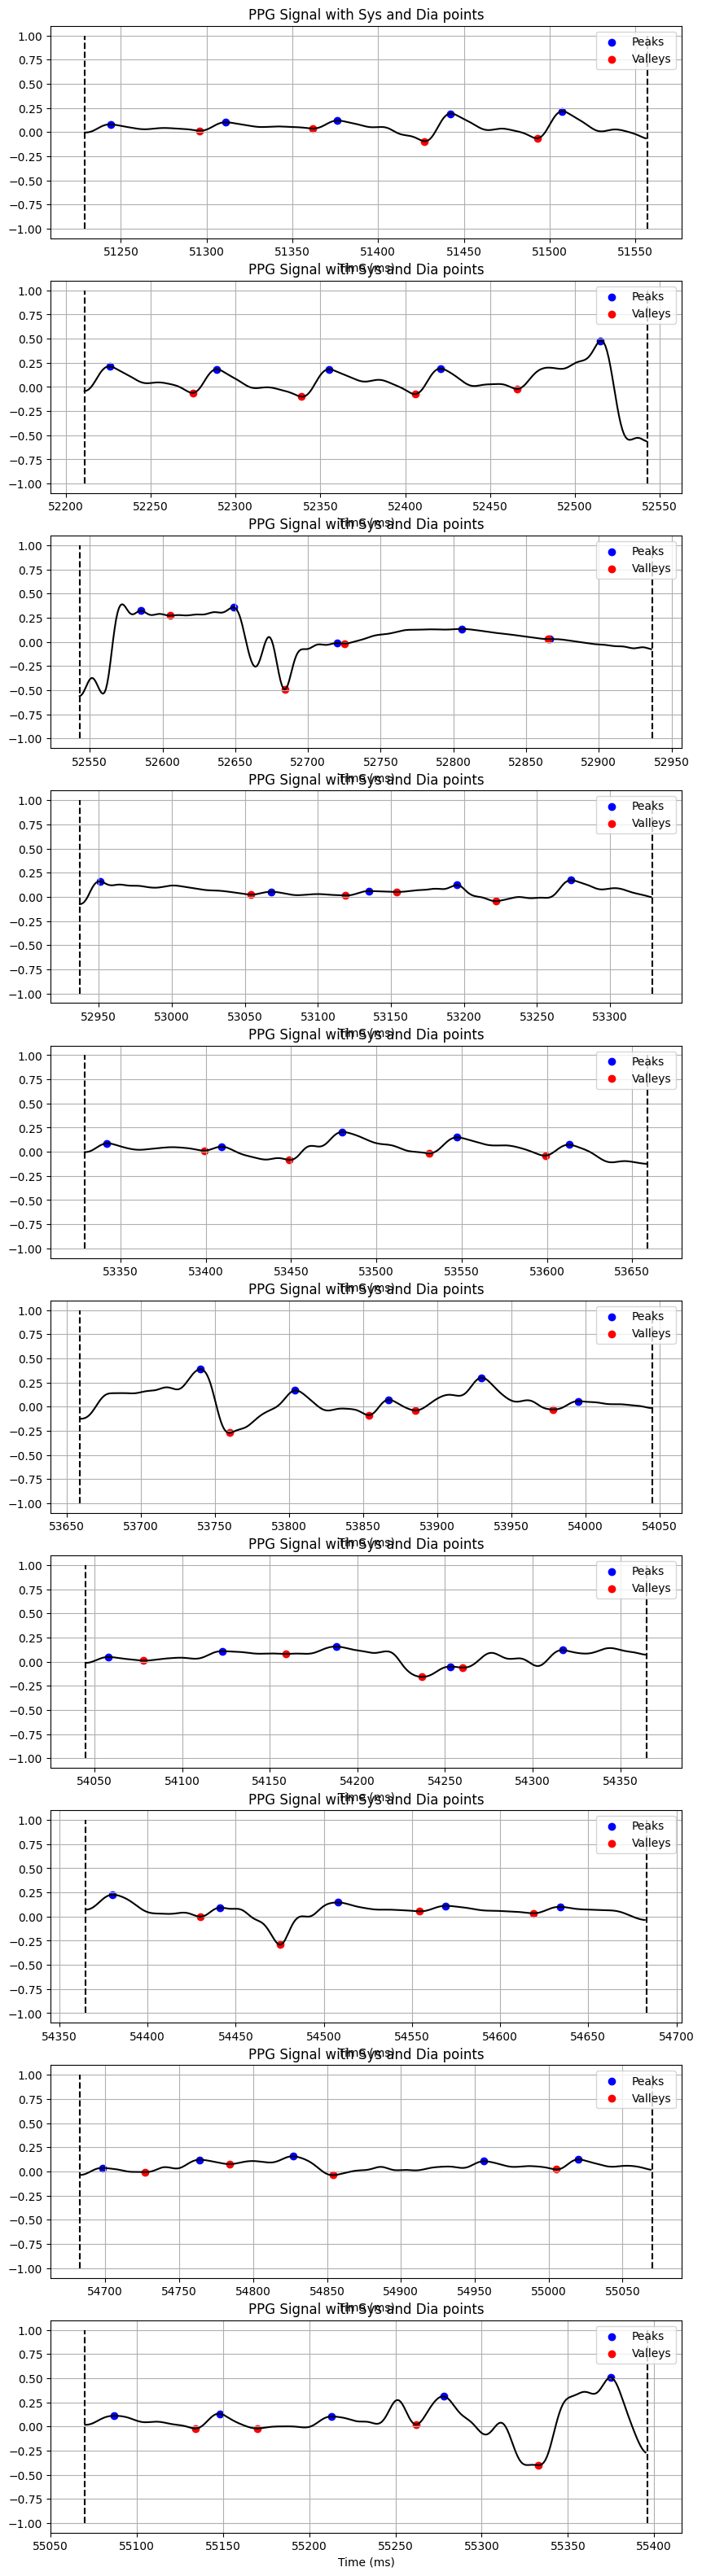

In [56]:
# Plot corrupted signal

fig1, ax1 = plt.subplots(10,1, figsize=(10,40))
onset_indx = 10

for i in range(0, 10):
    seg_s = win_indx[corrupted_win_indx[i+onset_indx], 0]
    seg_e = win_indx[corrupted_win_indx[i+onset_indx], 1]
    x_range = range(seg_s,seg_e)
    temp_peaks = [k for k in peaks_indx if k>seg_s and k<seg_e]
    temp_valleys = [m for m in valleys_indx if m>seg_s and m<seg_e]
    ax1[i].scatter(temp_peaks, LPF_sig[temp_peaks], c ='b', marker='o',label='Peaks')
    ax1[i].scatter(temp_valleys, LPF_sig[temp_valleys], c='r', marker='o',label='Valleys')
    ax1[i].plot(x_range, LPF_sig[seg_s:seg_e], c='k')
    ax1[i].set_title("PPG Signal with Sys and Dia points")
    ax1[i].vlines(seg_s, -1, 1, colors='k', linestyles = '--')
    ax1[i].vlines(seg_e, -1, 1, colors='k', linestyles = '--')
    ax1[i].grid(True)
    ax1[i].legend()
    ax1[i].set_xlim(seg_s-20, seg_e+20)
    ax1[i].set_xlabel('Time (ms)')

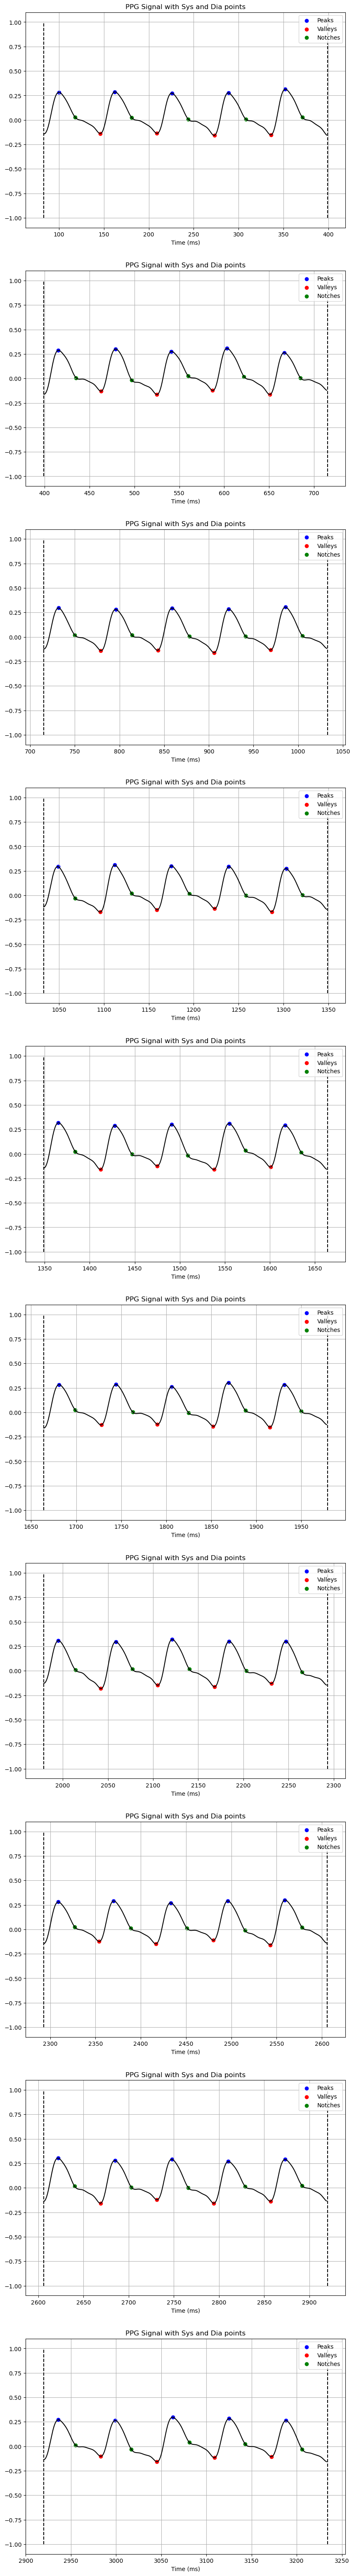

In [46]:
# Plot normal signal

fig2, ax2 = plt.subplots(10,1, figsize=(10,80))
onset_indx = 0

for i in range(0, 10):
    seg_s = ACF_win_indx[i+onset_indx, 0]
    seg_e = ACF_win_indx[i+onset_indx, 1]
    x_range = range(seg_s,seg_e)
    temp_peaks = [k for k in peaks_indx if k>seg_s and k<seg_e]
    temp_valleys = [m for m in valleys_indx if m>seg_s and m<seg_e]
    temp_notches = [l for l in dnotch_indx if l>seg_s and l<seg_e]
    ax2[i].scatter(temp_peaks, LPF_sig[temp_peaks], c ='b', marker='o',label='Peaks')
    ax2[i].scatter(temp_valleys, LPF_sig[temp_valleys], c='r', marker='o',label='Valleys')
    ax2[i].scatter(temp_notches, LPF_sig[temp_notches], c='g', marker='o',label='Notches')
    ax2[i].plot(x_range, LPF_sig[seg_s:seg_e], c='k')
    ax2[i].set_title("PPG Signal with Sys and Dia points")
    ax2[i].vlines(seg_s, -1, 1, colors='k', linestyles = '--')
    ax2[i].vlines(seg_e, -1, 1, colors='k', linestyles = '--')
    ax2[i].grid(True)
    ax2[i].legend()
    ax2[i].set_xlim(seg_s-20, seg_e+20)
    ax2[i].set_xlabel('Time (ms)')

In [26]:
#Split ppg data into segments 7second

sam_fs = 125
seg_size = 7*sam_fs #second
seg_n = LPF_sig.shape[0]//seg_size #남는 데이터 무시, 원본 신호도 없애 버릴 것
Feature=np.empty((0,4))
peaks_indx_indx = 0

for i in range(seg_n):
    seg_Feature = np.empty((0,))
    seg_Tn = np.empty((0,))
    seg_An = np.empty((0,))
    seg_s = i*seg_size
    seg_e = (i+1)*seg_size
    K = Kurtosis(LPF_sig[seg_s:seg_e])
    for k in range(peaks_indx_indx, peaks_indx.shape[0]):
        if peaks_indx[k] > seg_s and peaks_indx[k] < seg_e:
            seg_Tn = np.append(seg_Tn, peaks_indx[k+1]-peaks_indx[k])
            seg_An = np.append(seg_An, LPF_sig[peaks_indx[k]]-LPF_sig[valleys_indx[k]])
        elif peaks_indx[k] > seg_e:
            Feature = np.insert(Feature,Feature.shape[0],[np.std(seg_An), np.mean(seg_An), np.std(seg_Tn),K],axis=0)
            peaks_indx_indx = k
            break

Text(0.5, 1.0, 'skewness')

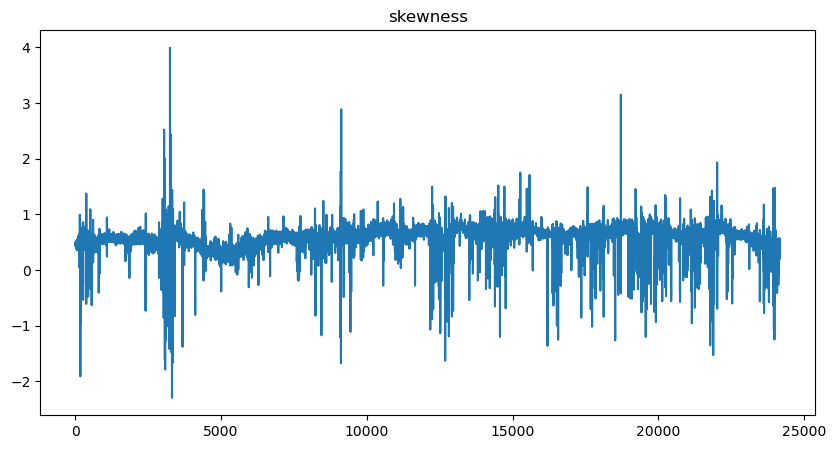

In [99]:
#skewness plot
# 5개의 펄스 단위로 Skewness 적용
step = 5
skewness_array = np.empty((0,2))
for i in range(peaks_indx.shape[0]//5-1):
    seg_e = peaks_indx[i*5+5]
    seg_s = peaks_indx[i*5]
    skewness_array = np.insert(skewness_array,skewness_array.shape[0], [seg_s, Skewness(LPF_sig[seg_s:seg_e])], axis = 0)
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(range(skewness_array.shape[0]), skewness_array[:,1])
ax2.set_title('skewness')

In [ ]:
#5초간 심박수 제한(40~120)
win_size = 5 #second
Win_sig = np.empty((0,125*win_size)) #5초간의 데이터 윈도우, 데이터 단위 행벡터

LPF_sig_2d = np.reshape(LPF_sig, (1, LPF_sig.shape[0]))
for i in valleys_indx[10::5]: #5개의 펄스가 있으면 되므로, 5개 펄스 단위로 끊어 
    new_win = np.reshape(LPF_sig_2d[0, i-375:i], (-1,375))
    Win_sig = np.concatenate((Win_sig, new_win), axis=0)

Text(0.5, 0, 'Time (ms)')

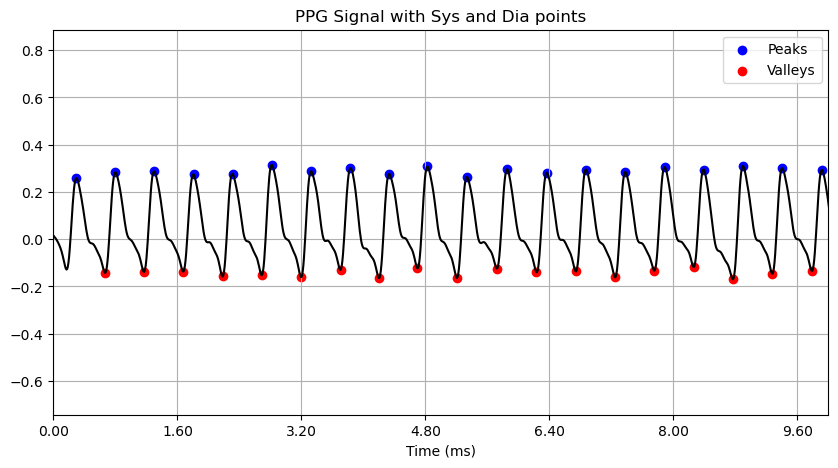

In [25]:
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(LPF_sig, c='k')
ax1.scatter(peaks_indx, LPF_sig[peaks_indx], c ='b', marker='o',label='Peaks')
ax1.scatter(valleys_indx, LPF_sig[valleys_indx], c='r', marker='o',label='Valleys')
ax1.set_title("PPG Signal with Sys and Dia points")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.2f}'.format(x/125)))
ax1.legend()
ax1.set_xlim(0, 1250)
ax1.set_xlabel('Time (ms)')

In [97]:
a = np.array([[1,2,3,4,5],[2,3,4,5,6]])
e = np.empty((0,5))
b = np.array([1,2,3,4,5])
b = np.reshape(b,(-1,5))
c=np.concatenate((e,b),axis=0)

In [40]:
TAOC = np.empty((0,))
S = 0
for i in range(ZCI.shape[1]):
    S = NPCFD_sig[ZCI[0,i]]
    for k in range(ZCI[0,i]+1, ZCI[1,i]+1):
        S += 2*NPCFD_sig[k]
    S /= 2
    TAOC = np.append(TAOC, round(S))

In [41]:
TAOC_plt = np.zeros((NPCFD_sig.shape[0],))
for i in range(ZCI.shape[1]):
    for k in range(ZCI[0,i]+1, ZCI[1,i]+1):
        TAOC_plt[k] = TAOC[i]

(-0.1, 0.1)

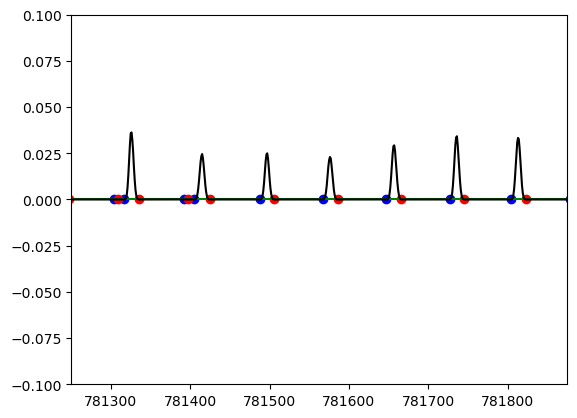

In [54]:
ZCI_y = np.zeros((ZCI.shape[1],))

n = 1250
jump_sam = 625
lim_start = jump_sam*n
lim_end = lim_start + jump_sam

ps = 0
pe = ZCI.shape[0]-1
fig1, ax1 = plt.subplots()
ax1.scatter(ZCI[0,:], ZCI_y, color = 'b')
ax1.scatter(ZCI[1,:], ZCI_y, color = 'r')
ax1.plot(TAOC_plt, color = 'g')
ax1.plot(NPCFD_sig, color = 'k')
ax1.set_xlim(lim_start, lim_end)
ax1.set_ylim(-0.1, 0.1)

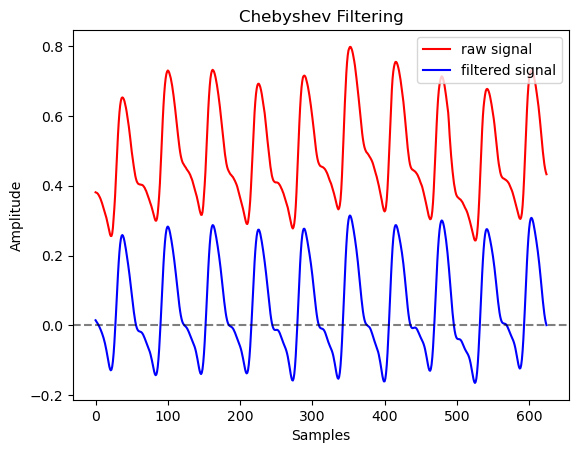

In [111]:
plt.plot(ppg_sig[:625], color = 'r', label = 'raw signal')
plt.plot(LPF_sig[:625], color = 'b', label = 'filtered signal')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Chebyshev Filtering')
plt.legend()

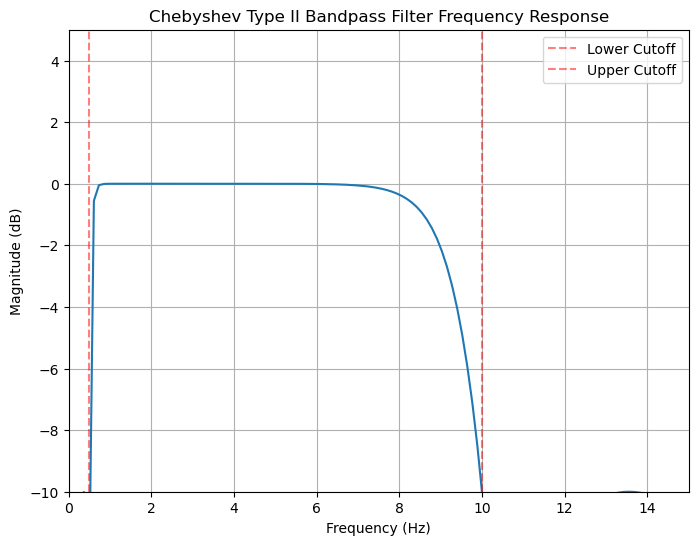

In [71]:
# Plot the frequency response
w, h = freqz(b, a, fs=fs)
plt.figure(figsize=(8, 6))
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Chebyshev Type II Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.xlim(0, 15)
plt.ylim(-10, 5)
plt.axvline(cutoff_freq[0], color='r', linestyle='--', alpha=0.5, label='Lower Cutoff')
plt.axvline(cutoff_freq[1], color='r', linestyle='--', alpha=0.5, label='Upper Cutoff')
plt.legend()
plt.show()